In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import os

Using TensorFlow backend.


In [2]:
from keras import regularizers

In [3]:
mylist= os.listdir('data/')

In [4]:
type(mylist)

list

In [5]:
print(mylist[10])

03-01-01-01-01-01-12.wav


In [6]:
print(mylist[40][6:-16])

01


In [7]:
data, sampling_rate = librosa.load('data/neutral1.wav')

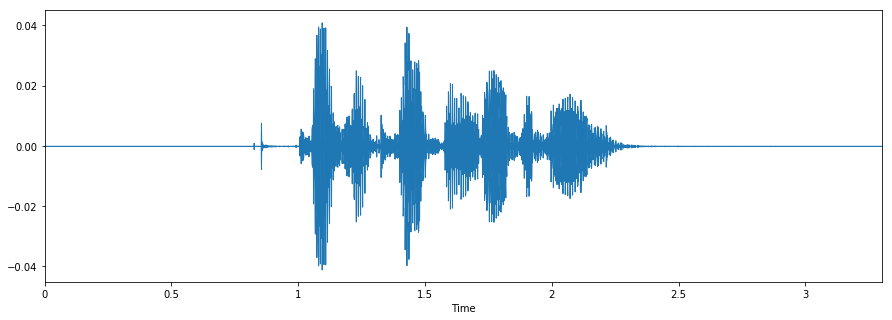

In [8]:
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

C:\Users\lenovo\Anaconda3\lib\site-packages\matplotlib\image.py:855: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-0.5, right=-0.5
  self.axes.set_xlim((xmin, xmax), auto=None)


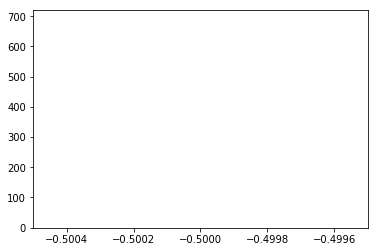

In [9]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


#sr,x = scipy.io.wavfile.read('data/neutral1.wav',mmap=True)
import io
from scipy.io.wavfile import read
import wave

def normalize_wav(input_file, output_file):
    with wave.open(input_file, "rb") as r_wav, wave.open(output_file, "wb") as w_wav:
        w_wav.setparams(r_wav.getparams())
        w_wav.writeframes(r_wav.readframes(w_wav.getnframes()))

buff = io.BytesIO()
normalize_wav('data/neutral1.wav', buff)
buff.seek(0)
sr,x = read(buff)

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

In [10]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
    elif item[:1]=='a':
        feeling_list.append('male_angry')
    elif item[:1]=='f':
        feeling_list.append('male_fearful')
    elif item[:1]=='h':
        feeling_list.append('male_happy')
    #elif item[:1]=='n':
        #feeling_list.append('neutral')
    elif item[:2]=='sa':
        feeling_list.append('male_sad')

In [11]:
labels = pd.DataFrame(feeling_list)

In [12]:
labels[:10]

,0
0,female_calm
1,male_calm
2,female_calm
3,male_calm
4,female_calm
5,male_calm
6,female_calm
7,male_calm
8,female_calm
9,male_calm


In [13]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
        X, sample_rate = librosa.load('data/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        #[float(i) for i in feature]
        #feature1=feature[:135]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1

In [14]:
df[:5]

,feature
0,"[-65.70765, -65.70765, -63.11472, -61.518997, ..."
1,"[-65.4825, -65.4825, -65.4825, -65.4825, -65.4..."
2,"[-64.52845, -64.52845, -64.52845, -64.52845, -..."
3,"[-62.36431, -59.93473, -61.869602, -67.495766,..."
4,"[-71.288345, -71.288345, -71.288345, -71.28834..."


In [15]:
df3 = pd.DataFrame(df['feature'].values.tolist())

In [16]:
newdf = pd.concat([df3,labels], axis=1)

In [17]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [18]:
rnewdf[:5]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
0,-65.707649,-65.707649,-63.114719,-61.518997,-61.097134,-63.424595,-63.720058,-56.854614,-55.168972,-54.640007,...,-39.792141,-40.613159,-41.209202,-41.439194,-43.994286,-49.399620,-50.591599,-49.144062,-48.705647,female_calm
1,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,...,-31.346554,-34.310772,-35.800705,-35.936115,-37.631844,-40.119411,-41.662903,-41.323643,-40.710770,male_calm
2,-64.528450,-64.528450,-64.528450,-64.528450,-64.528450,-64.528450,-64.528450,-64.528450,-64.528450,-65.928223,...,-48.674301,-48.596077,-47.602749,-43.049198,-42.659538,-43.188564,-44.001240,-43.610100,-44.698250,female_calm
3,-62.364311,-59.934731,-61.869602,-67.495766,-71.071815,-65.679817,-63.394402,-65.503349,-61.856636,-60.005424,...,-39.071320,-41.897129,-40.865433,-38.290604,-36.372398,-37.915783,-40.026127,-43.383770,-43.965401,male_calm
4,-71.288345,-71.288345,-71.288345,-71.288345,-71.288345,-71.288345,-71.288345,-71.288345,-71.288345,-71.288345,...,-45.439762,-45.199463,-43.801682,-44.768456,-46.546829,-45.922283,-46.734531,-42.166695,-37.963127,female_calm


In [19]:

from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
317,-44.929764,-45.915077,-48.502754,-50.057381,-50.445156,-51.035885,-51.243423,-51.221672,-50.785576,-50.070919,...,-24.733873,-22.042908,-21.389210,-22.735104,-21.326191,-19.974070,-19.913639,-18.530849,-14.574443,male_happy
877,-50.922508,-46.728203,-45.134315,-45.604366,-45.114830,-44.592960,-45.553383,-45.842388,-45.717918,-46.047836,...,-38.503208,-39.523758,-40.019905,-41.528805,-42.962498,-42.645603,-42.775723,-42.864445,-42.943764,male_fearful
277,-53.070736,-51.800091,-50.760410,-52.047302,-51.221233,-51.671104,-51.556725,-52.577854,-53.201706,-52.130268,...,-53.811703,-54.319889,-55.268959,-52.052856,-50.433273,-53.498554,-53.312832,-52.798386,-51.479801,male_happy
304,-40.588501,-40.581081,-40.605572,-40.649166,-40.645645,-40.654915,-40.655987,-40.645638,-40.632103,-40.652580,...,-37.957699,-37.451443,-39.119526,-39.735306,-40.298763,-40.656857,-40.656857,-40.656857,-40.656857,female_happy
102,-55.193134,-55.723881,-56.979527,-60.773300,-55.671585,-53.729595,-53.668484,-53.156345,-54.001930,-55.969082,...,-52.854710,-49.178703,-49.217075,-50.817707,-50.598225,-50.945152,-50.485638,-51.919376,-52.982174,female_calm
367,-41.152237,-41.695740,-39.584538,-38.757969,-38.952866,-40.042168,-40.949989,-40.641487,-41.340652,-42.487789,...,-45.526016,-47.148186,-46.474819,-44.839092,-46.956478,-47.138290,-48.784267,-46.908516,-45.789280,male_happy
741,-40.758728,-40.758728,-40.487358,-40.758728,-40.648575,-39.472900,-39.716457,-40.758728,-40.758728,-40.758728,...,-40.758728,-40.758728,-40.758728,-40.758728,-40.758728,-40.758728,-40.758728,-40.758728,-40.758728,male_angry
279,-50.683449,-49.582844,-49.573147,-49.530697,-51.778389,-49.248268,-49.240765,-49.972069,-51.259541,-50.161118,...,-50.108318,-50.828201,-51.525124,-50.562870,-49.983562,-52.057095,-50.964302,-50.562965,-51.980816,male_happy
460,-72.317825,-72.317825,-72.317825,-72.317825,-72.317825,-72.317825,-72.317825,-72.317825,-72.317825,-72.317825,...,-64.586044,-64.523933,-64.174210,-66.311821,-63.141403,-60.602013,-63.572910,-64.221634,-63.324245,female_sad
514,-46.456718,-47.024212,-46.142891,-46.262913,-46.480347,-46.620770,-47.260395,-46.667107,-47.757446,-46.490688,...,-45.584679,-43.598026,-46.936806,-47.840889,-48.035343,-47.782524,-45.367886,-45.400936,-47.511478,female_sad


In [20]:
rnewdf=rnewdf.fillna(0)

In [21]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [22]:
trainfeatures = train.iloc[:, :-1]

In [23]:
trainlabel = train.iloc[:, -1:]

In [24]:
testfeatures = test.iloc[:, :-1]

In [25]:
testlabel = test.iloc[:, -1:]

In [26]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [27]:
X_train.shape

(765, 216)

In [28]:
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [33]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

In [34]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 216, 256)          1536      
_________________________________________________________________
activation_6 (Activation)    (None, 216, 256)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 216, 128)          163968    
_________________________________________________________________
activation_7 (Activation)    (None, 216, 128)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 27, 128)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 27, 128)          

In [35]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [36]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700, validation_data=(x_testcnn, y_test))

W0922 08:15:41.096383  9408 deprecation_wrapper.py:119] From C:\Users\lenovo\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 765 samples, validate on 194 samples
Epoch 1/700
765/765 [==============================] - 5s 6ms/step - loss: 2.9849 - accuracy: 0.0915 - val_loss: 2.3227 - val_accuracy: 0.1186
Epoch 2/700
765/765 [==============================] - 4s 5ms/step - loss: 2.3100 - accuracy: 0.1190 - val_loss: 2.2661 - val_accuracy: 0.1598
Epoch 3/700
765/765 [==============================] - 4s 5ms/step - loss: 2.2634 - accuracy: 0.1673 - val_loss: 2.2406 - val_accuracy: 0.1701
Epoch 4/700
765/765 [==============================] - 4s 5ms/step - loss: 2.2376 - accuracy: 0.1712 - val_loss: 2.2194 - val_accuracy: 0.1649
Epoch 5/700
765/765 [==============================] - 4s 5ms/step - loss: 2.2075 - accuracy: 0.1621 - val_loss: 2.2009 - val_accuracy: 0.2165
Epoch 6/700
765/765 [==============================] - 4s 5ms/step - loss: 2.1785 - accuracy: 0.1961 - val_loss: 2.1631 - val_accuracy: 0.2268
Epoch 7/700
765/765 [==============================] - 4s 5ms/step - loss: 2.1538 - accuracy: 0.

765/765 [==============================] - 4s 5ms/step - loss: 1.6026 - accuracy: 0.4196 - val_loss: 1.6635 - val_accuracy: 0.4021
Epoch 58/700
765/765 [==============================] - 4s 5ms/step - loss: 1.5869 - accuracy: 0.4183 - val_loss: 1.6542 - val_accuracy: 0.4021
Epoch 59/700
765/765 [==============================] - 4s 5ms/step - loss: 1.5923 - accuracy: 0.4118 - val_loss: 1.6372 - val_accuracy: 0.4433
Epoch 60/700
765/765 [==============================] - 4s 5ms/step - loss: 1.5896 - accuracy: 0.4092 - val_loss: 1.6493 - val_accuracy: 0.3918
Epoch 61/700
765/765 [==============================] - 4s 5ms/step - loss: 1.5791 - accuracy: 0.4078 - val_loss: 1.6372 - val_accuracy: 0.3969
Epoch 62/700
765/765 [==============================] - 4s 5ms/step - loss: 1.5651 - accuracy: 0.4170 - val_loss: 1.6208 - val_accuracy: 0.3918
Epoch 63/700
765/765 [==============================] - 4s 5ms/step - loss: 1.5540 - accuracy: 0.4327 - val_loss: 1.6963 - val_accuracy: 0.3711
Epoch

Epoch 114/700
765/765 [==============================] - 4s 5ms/step - loss: 1.3224 - accuracy: 0.5190 - val_loss: 1.4545 - val_accuracy: 0.4485
Epoch 115/700
765/765 [==============================] - 4s 5ms/step - loss: 1.3256 - accuracy: 0.5046 - val_loss: 1.4261 - val_accuracy: 0.4536
Epoch 116/700
765/765 [==============================] - 4s 5ms/step - loss: 1.3260 - accuracy: 0.5163 - val_loss: 1.4219 - val_accuracy: 0.4691
Epoch 117/700
765/765 [==============================] - 4s 5ms/step - loss: 1.3255 - accuracy: 0.4954 - val_loss: 1.4331 - val_accuracy: 0.4897
Epoch 118/700
765/765 [==============================] - 4s 5ms/step - loss: 1.3232 - accuracy: 0.5007 - val_loss: 1.4428 - val_accuracy: 0.4381
Epoch 119/700
765/765 [==============================] - 4s 5ms/step - loss: 1.3114 - accuracy: 0.4993 - val_loss: 1.4241 - val_accuracy: 0.5103
Epoch 120/700
765/765 [==============================] - 4s 5ms/step - loss: 1.3105 - accuracy: 0.5046 - val_loss: 1.3956 - val_ac

765/765 [==============================] - 4s 5ms/step - loss: 1.1864 - accuracy: 0.5516 - val_loss: 1.3825 - val_accuracy: 0.5000
Epoch 171/700
765/765 [==============================] - 4s 5ms/step - loss: 1.1918 - accuracy: 0.5333 - val_loss: 1.4155 - val_accuracy: 0.4433
Epoch 172/700
765/765 [==============================] - 4s 5ms/step - loss: 1.1821 - accuracy: 0.5516 - val_loss: 1.3217 - val_accuracy: 0.5052
Epoch 173/700
765/765 [==============================] - 4s 5ms/step - loss: 1.1861 - accuracy: 0.5608 - val_loss: 1.3411 - val_accuracy: 0.4691
Epoch 174/700
765/765 [==============================] - 4s 5ms/step - loss: 1.1861 - accuracy: 0.5647 - val_loss: 1.4284 - val_accuracy: 0.4845
Epoch 175/700
765/765 [==============================] - 4s 5ms/step - loss: 1.1794 - accuracy: 0.5412 - val_loss: 1.3506 - val_accuracy: 0.5258
Epoch 176/700
765/765 [==============================] - 4s 5ms/step - loss: 1.1729 - accuracy: 0.5660 - val_loss: 1.3570 - val_accuracy: 0.5000

765/765 [==============================] - 4s 5ms/step - loss: 1.0862 - accuracy: 0.6000 - val_loss: 1.3046 - val_accuracy: 0.5155
Epoch 227/700
765/765 [==============================] - 4s 5ms/step - loss: 1.0694 - accuracy: 0.6222 - val_loss: 1.3482 - val_accuracy: 0.5052
Epoch 228/700
765/765 [==============================] - 4s 5ms/step - loss: 1.0588 - accuracy: 0.6131 - val_loss: 1.3194 - val_accuracy: 0.5155
Epoch 229/700
765/765 [==============================] - 4s 5ms/step - loss: 1.0783 - accuracy: 0.5948 - val_loss: 1.3323 - val_accuracy: 0.5258
Epoch 230/700
765/765 [==============================] - 4s 5ms/step - loss: 1.0748 - accuracy: 0.6131 - val_loss: 1.3362 - val_accuracy: 0.4897
Epoch 231/700
765/765 [==============================] - 4s 5ms/step - loss: 1.0571 - accuracy: 0.6314 - val_loss: 1.3332 - val_accuracy: 0.5155
Epoch 232/700
765/765 [==============================] - 4s 5ms/step - loss: 1.0613 - accuracy: 0.6052 - val_loss: 1.3119 - val_accuracy: 0.4897

765/765 [==============================] - 3s 5ms/step - loss: 0.9669 - accuracy: 0.6549 - val_loss: 1.3304 - val_accuracy: 0.4742
Epoch 283/700
765/765 [==============================] - 3s 5ms/step - loss: 0.9683 - accuracy: 0.6562 - val_loss: 1.3376 - val_accuracy: 0.5258
Epoch 284/700
765/765 [==============================] - 3s 4ms/step - loss: 0.9661 - accuracy: 0.6641 - val_loss: 1.3247 - val_accuracy: 0.5103
Epoch 285/700
765/765 [==============================] - 4s 5ms/step - loss: 0.9701 - accuracy: 0.6418 - val_loss: 1.3062 - val_accuracy: 0.5000
Epoch 286/700
765/765 [==============================] - 3s 4ms/step - loss: 0.9642 - accuracy: 0.6562 - val_loss: 1.3064 - val_accuracy: 0.4948
Epoch 287/700
765/765 [==============================] - 3s 5ms/step - loss: 0.9626 - accuracy: 0.6654 - val_loss: 1.3339 - val_accuracy: 0.4845
Epoch 288/700
765/765 [==============================] - 4s 5ms/step - loss: 0.9664 - accuracy: 0.6458 - val_loss: 1.2758 - val_accuracy: 0.5103

765/765 [==============================] - 4s 5ms/step - loss: 0.8774 - accuracy: 0.7007 - val_loss: 1.3082 - val_accuracy: 0.5052
Epoch 339/700
765/765 [==============================] - 3s 5ms/step - loss: 0.8558 - accuracy: 0.7085 - val_loss: 1.2906 - val_accuracy: 0.4897
Epoch 340/700
765/765 [==============================] - 4s 5ms/step - loss: 0.8593 - accuracy: 0.7150 - val_loss: 1.3906 - val_accuracy: 0.4588
Epoch 341/700
765/765 [==============================] - 3s 4ms/step - loss: 0.8737 - accuracy: 0.6941 - val_loss: 1.3752 - val_accuracy: 0.4639
Epoch 342/700
765/765 [==============================] - 3s 4ms/step - loss: 0.8528 - accuracy: 0.7163 - val_loss: 1.3421 - val_accuracy: 0.4588
Epoch 343/700
765/765 [==============================] - 3s 4ms/step - loss: 0.8559 - accuracy: 0.7072 - val_loss: 1.3884 - val_accuracy: 0.4897
Epoch 344/700
765/765 [==============================] - 4s 5ms/step - loss: 0.8561 - accuracy: 0.6876 - val_loss: 1.3655 - val_accuracy: 0.4742

765/765 [==============================] - 3s 5ms/step - loss: 0.7728 - accuracy: 0.7399 - val_loss: 1.3372 - val_accuracy: 0.5103
Epoch 395/700
765/765 [==============================] - 3s 5ms/step - loss: 0.7689 - accuracy: 0.7386 - val_loss: 1.3911 - val_accuracy: 0.4485
Epoch 396/700
765/765 [==============================] - 4s 5ms/step - loss: 0.7621 - accuracy: 0.7425 - val_loss: 1.3648 - val_accuracy: 0.4691
Epoch 397/700
765/765 [==============================] - 4s 5ms/step - loss: 0.7563 - accuracy: 0.7556 - val_loss: 1.4127 - val_accuracy: 0.4381
Epoch 398/700
765/765 [==============================] - 3s 5ms/step - loss: 0.7661 - accuracy: 0.7359 - val_loss: 1.3737 - val_accuracy: 0.4536
Epoch 399/700
765/765 [==============================] - 4s 5ms/step - loss: 0.7653 - accuracy: 0.7373 - val_loss: 1.4262 - val_accuracy: 0.4278
Epoch 400/700
765/765 [==============================] - 4s 5ms/step - loss: 0.7618 - accuracy: 0.7621 - val_loss: 1.3266 - val_accuracy: 0.4897

765/765 [==============================] - 5s 6ms/step - loss: 0.6748 - accuracy: 0.7817 - val_loss: 1.3340 - val_accuracy: 0.4948
Epoch 451/700
765/765 [==============================] - 5s 6ms/step - loss: 0.6667 - accuracy: 0.7673 - val_loss: 1.3755 - val_accuracy: 0.4691
Epoch 452/700
765/765 [==============================] - 5s 6ms/step - loss: 0.6623 - accuracy: 0.7739 - val_loss: 1.4211 - val_accuracy: 0.4742
Epoch 453/700
765/765 [==============================] - 4s 6ms/step - loss: 0.6711 - accuracy: 0.7739 - val_loss: 1.3730 - val_accuracy: 0.5155
Epoch 454/700
765/765 [==============================] - 4s 5ms/step - loss: 0.6634 - accuracy: 0.7843 - val_loss: 1.3817 - val_accuracy: 0.4948
Epoch 455/700
765/765 [==============================] - 4s 5ms/step - loss: 0.6604 - accuracy: 0.7804 - val_loss: 1.4044 - val_accuracy: 0.4742
Epoch 456/700
765/765 [==============================] - 5s 7ms/step - loss: 0.6619 - accuracy: 0.7895 - val_loss: 1.5830 - val_accuracy: 0.4072

765/765 [==============================] - 4s 5ms/step - loss: 0.5780 - accuracy: 0.8183 - val_loss: 1.4454 - val_accuracy: 0.4433
Epoch 507/700
765/765 [==============================] - 4s 5ms/step - loss: 0.5727 - accuracy: 0.8209 - val_loss: 1.4377 - val_accuracy: 0.4588
Epoch 508/700
765/765 [==============================] - 4s 5ms/step - loss: 0.5797 - accuracy: 0.8092 - val_loss: 1.3691 - val_accuracy: 0.5000
Epoch 509/700
765/765 [==============================] - 3s 5ms/step - loss: 0.5704 - accuracy: 0.8222 - val_loss: 1.4163 - val_accuracy: 0.5052
Epoch 510/700
765/765 [==============================] - 3s 5ms/step - loss: 0.5657 - accuracy: 0.8248 - val_loss: 1.4869 - val_accuracy: 0.4639
Epoch 511/700
765/765 [==============================] - 4s 5ms/step - loss: 0.5718 - accuracy: 0.8144 - val_loss: 1.3901 - val_accuracy: 0.4948
Epoch 512/700
765/765 [==============================] - 3s 5ms/step - loss: 0.5718 - accuracy: 0.8288 - val_loss: 1.3703 - val_accuracy: 0.5052

765/765 [==============================] - 4s 5ms/step - loss: 0.4784 - accuracy: 0.8458 - val_loss: 1.4516 - val_accuracy: 0.4588
Epoch 563/700
765/765 [==============================] - 3s 4ms/step - loss: 0.4755 - accuracy: 0.8523 - val_loss: 1.4560 - val_accuracy: 0.4948
Epoch 564/700
765/765 [==============================] - 3s 5ms/step - loss: 0.4760 - accuracy: 0.8588 - val_loss: 1.4853 - val_accuracy: 0.4639
Epoch 565/700
765/765 [==============================] - 3s 4ms/step - loss: 0.4813 - accuracy: 0.8536 - val_loss: 1.4234 - val_accuracy: 0.4691
Epoch 566/700
765/765 [==============================] - 3s 4ms/step - loss: 0.4731 - accuracy: 0.8366 - val_loss: 1.4795 - val_accuracy: 0.4845
Epoch 567/700
765/765 [==============================] - 4s 5ms/step - loss: 0.4790 - accuracy: 0.8471 - val_loss: 1.4292 - val_accuracy: 0.4948
Epoch 568/700
765/765 [==============================] - 3s 5ms/step - loss: 0.4771 - accuracy: 0.8536 - val_loss: 1.4589 - val_accuracy: 0.4639

765/765 [==============================] - 3s 5ms/step - loss: 0.3840 - accuracy: 0.8941 - val_loss: 1.5110 - val_accuracy: 0.4691
Epoch 619/700
765/765 [==============================] - 4s 5ms/step - loss: 0.3871 - accuracy: 0.8967 - val_loss: 1.5711 - val_accuracy: 0.4588
Epoch 620/700
765/765 [==============================] - 3s 5ms/step - loss: 0.3744 - accuracy: 0.8967 - val_loss: 1.5372 - val_accuracy: 0.4794
Epoch 621/700
765/765 [==============================] - 4s 5ms/step - loss: 0.3829 - accuracy: 0.8902 - val_loss: 1.4988 - val_accuracy: 0.5052
Epoch 622/700
765/765 [==============================] - 4s 5ms/step - loss: 0.3827 - accuracy: 0.8850 - val_loss: 1.5545 - val_accuracy: 0.4485
Epoch 623/700
765/765 [==============================] - 3s 5ms/step - loss: 0.3788 - accuracy: 0.8980 - val_loss: 1.4860 - val_accuracy: 0.4742
Epoch 624/700
765/765 [==============================] - 3s 4ms/step - loss: 0.3903 - accuracy: 0.8915 - val_loss: 1.5680 - val_accuracy: 0.5052

765/765 [==============================] - 3s 4ms/step - loss: 0.3039 - accuracy: 0.9255 - val_loss: 1.6667 - val_accuracy: 0.4381
Epoch 675/700
765/765 [==============================] - 3s 5ms/step - loss: 0.2968 - accuracy: 0.9229 - val_loss: 1.7467 - val_accuracy: 0.4072
Epoch 676/700
765/765 [==============================] - 3s 5ms/step - loss: 0.2956 - accuracy: 0.9229 - val_loss: 1.6391 - val_accuracy: 0.4948
Epoch 677/700
765/765 [==============================] - 4s 5ms/step - loss: 0.3008 - accuracy: 0.9307 - val_loss: 1.6254 - val_accuracy: 0.4588
Epoch 678/700
765/765 [==============================] - 3s 4ms/step - loss: 0.2941 - accuracy: 0.9320 - val_loss: 1.6616 - val_accuracy: 0.4124
Epoch 679/700
765/765 [==============================] - 4s 5ms/step - loss: 0.2936 - accuracy: 0.9320 - val_loss: 1.6089 - val_accuracy: 0.4742
Epoch 680/700
765/765 [==============================] - 3s 5ms/step - loss: 0.3000 - accuracy: 0.9268 - val_loss: 1.6465 - val_accuracy: 0.4794

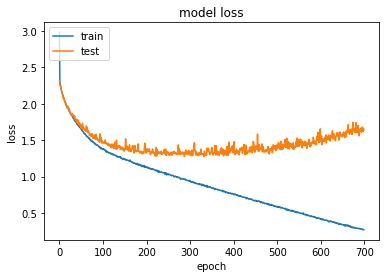

In [37]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [38]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:\Users\lenovo\Desktop\Emotion_Regognition\saved_models\Emotion_Voice_Detection_Model.h5 


In [39]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [40]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 46.39%


In [41]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

194/194 [==============================] - 0s 838us/step


In [42]:
preds1=preds.argmax(axis=1)

In [43]:
abc = preds1.astype(int).flatten()

In [44]:
predictions = (lb.inverse_transform((abc)))

In [45]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,male_angry
1,female_happy
2,female_sad
3,female_fearful
4,female_fearful
5,male_angry
6,female_happy
7,female_angry
8,female_sad
9,male_happy


In [46]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [47]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,male_happy
1,female_fearful
2,female_fearful
3,female_fearful
4,female_fearful
5,male_angry
6,female_sad
7,female_angry
8,female_sad
9,male_sad


In [48]:
finaldf = actualdf.join(preddf)

In [51]:
finaldf[0:140]

,actualvalues,predictedvalues
0,male_happy,male_angry
1,female_fearful,female_happy
2,female_fearful,female_sad
3,female_fearful,female_fearful
4,female_fearful,female_fearful
5,male_angry,male_angry
6,female_sad,female_happy
7,female_angry,female_angry
8,female_sad,female_sad
9,male_sad,male_happy


In [52]:

finaldf.to_csv('Predictions.csv', index=False)

In [53]:

#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('data/03-01-03-02-02-02-01.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [54]:
livedf2= pd.DataFrame(data=livedf2)

In [55]:

livedf2 = livedf2.stack().to_frame().T

In [56]:
livedf2

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-57.414993,-57.414993,-57.414993,-57.414993,-57.414993,-57.414993,-57.414993,-57.414993,-57.414993,-57.414993,...,-27.840111,-27.892956,-29.425554,-31.255728,-34.011845,-34.322586,-33.564934,-36.074425,-37.658695,-38.918003


In [57]:
twodim= np.expand_dims(livedf2, axis=2)

In [58]:

livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s 36ms/step


In [59]:
livepreds

array([[4.1952990e-03, 2.1430026e-03, 3.2129820e-02, 9.1444800e-04,
        1.4785588e-04, 2.1268935e-03, 5.3498585e-02, 1.4044413e-01,
        7.5640082e-01, 7.9990271e-03]], dtype=float32)

In [60]:
livepreds1=livepreds.argmax(axis=1)

In [61]:
liveabc = livepreds1.astype(int).flatten()

In [ ]:
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions